# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

## Content
- [Exploratory Data Analysis Part 1](#Exploratory_Data_Analysis1)<br>
    - [DataFrame preliminary Description](#describe_df)<br>
    - [Study DataFrame for based on userId](#df_example_study)<br>
- [Data Preparation](#data_prep)<br>
    - [Drop missing/uncommon values](#filter_data)<br>
    - [Define Churn - The Label for Machine Learning Modeling](#churn)<br>
    - [Distribution of churned and non churned users](#Distribution_of_churned_and_non_churned_users)<br> 
- [Exploratory Data Analysis Part 2](#Exploratory_Data_Analysis2)<br>
    - [Gender distribution based on churn](#Gender_distribution_based_on_churn)
    - [Total page activity based on churn](#Total_page_activity_based_on_churn)<br>
    - [Total number of songs played by user](#total_number_of_songs_played_by_user)<br>
    - [Average number of songs played by user](#Average_number_of_songs_played_by_user)<br>
    - [Average number of songs played per user per session](#Average_number_of_songs_played_by_user_per_session)<br>
    - [Total number of thumbs up per user](#total_number_of_thumbs_up_per_user)<br>
    - [Total number of thumbs down per user](#total_number_of_thumbs_down_per_user)<br>
    - [Total number of errors per user](#Total_number_of_errors_per_user)<br>
    - [Total number of "Add to Playlist" clicks per user](#Total_number_of_Add_to_playlist_clicks_per_user)<br>
    - [Total number of "Add Friend" clicks per user](#Total_number_of_Add_Friend_clicks_per_user)<br>
- [Feature Engineering](#Feature_Engineering)<br> 
- [Label Engineering for Prediction](#Label_Engineering)<br>  
    - 
    - [Define Churn - Analysing Downgrade Events](#downgrade)<br>
   

In [192]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType, FloatType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum,  min, max
import pyspark.sql.functions as psqf
from pyspark.sql.functions import col, countDistinct,  mean as _mean, stddev as _stddev
#from pyspark.sql import Window

from pyspark.sql.window import Window

from pyspark.sql import functions as F

from pyspark.sql.types import TimestampType

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from IPython.display import Markdown, display, HTML
def printmd(string):
    display(Markdown(string))

In [125]:
# Some UDF needed in the notebook

# Convert timestamps to datetime from epoch time to get the hour of the day. Create a user defined function called get_hour
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)

# Convert epoch time in milliseconds to econds
get_seconds = udf(lambda x: x / 1000.0)

# Convert epoch time in milliseconds to days
get_days = udf(lambda x: x / (1000.0 * 3600 * 24))

In [82]:
def plot_sns_bar(x, y, data, hue=None, log=False, title='', xlabel='x', ylabel='y', legend='', figsize=(8,5), save=False, hide_xtick=False, rotation=0, order=False, sort_by='', ascending=False):
    """ plot sns bar plot
        INPUTS:
        ------------
            x - (string) column name of DataFrame used as xaxis
            y - (string) column name of DataFrame used as yaxis
            hue - (string) grouping variable 
            data - (pandas dataframe) dataframe used fot plotting
            log - (bool) if True use logarithmic scale for y axis, else linear 
            title - (string) title of plot
            xlabel - (string) xlabel name 
            ylabel - (string) ylabel name
            save - (bool) if True save plot as png
            hide_xtick - (bool) if True hide xtick labels
            rotation - (int) angle in degrees forxlabel rotation
            order - (bool) if True order xaxis by sort_by
            sort_by (string) name of dataframe column for which xaxis should be ordered
            ascending - (bool) if True use ascending order for sort
                            
     
        OUTPUTS:
        ------------
            No return
            seaborn plot 
            png export 
            
    """
    fig = plt.figure(figsize=figsize)
    # make barplot and sort bars
    if order == True:
        g1 = sns.barplot(x=x,
                    y=y, 
                    data=data, 
                    log=log,
                    hue=hue,
                    order=data.sort_values(sort_by, ascending=ascending)[x])
    else:
        g1 = sns.barplot(x=x,
                    y=y, 
                    data=data,
                    log=log,
                    hue=hue)
        
    # set labels
    if hide_xtick == True:
        g1.set(xticklabels=[])  # remove the tick labels
    plt.xlabel(xlabel, size=15)
    plt.ylabel(ylabel, size=15)
    plt.xticks(rotation=rotation)
    plt.title(title, size=18)
    if legend !='':
        plt.legend(title=legend, loc='best')
    plt.tight_layout()
    if save == True:
        name = title.replace(' ', '_')
        plt.savefig(".png", dpi=100)
        

In [221]:
def plot_sns_box(x, y, data, title='', xlabel='x', ylabel='y', legend='', figsize=(8,5), save=False, hide_xtick=False, rotation=0, order=False, sort_by='', ascending=False):
    """ plot sns bar plot
        INPUTS:
        ------------
            x - (string) column name of DataFrame used as xaxis
            y - (string) column name of DataFrame used as yaxis
            hue - (string) grouping variable 
            data - (pandas dataframe) dataframe used fot plotting
            log - (bool) if True use logarithmic scale for y axis, else linear 
            title - (string) title of plot
            xlabel - (string) xlabel name 
            ylabel - (string) ylabel name
            save - (bool) if True save plot as png
            hide_xtick - (bool) if True hide xtick labels
            rotation - (int) angle in degrees forxlabel rotation
            order - (bool) if True order xaxis by sort_by
            sort_by (string) name of dataframe column for which xaxis should be ordered
            ascending - (bool) if True use ascending order for sort
                            
     
        OUTPUTS:
        ------------
            No return
            seaborn plot 
            png export 
            
    """
    fig = plt.figure(figsize=figsize)
    # make barplot and sort bars
    if order == True:
        g1 = sns.boxplot(x=x,
                    y=y, 
                    data=data, 
                    order=data.sort_values(sort_by, ascending=ascending)[x])
    else:
        g1 = sns.boxplot(x=x,
                    y=y, 
                    data=data)
                    
        
    # set labels
    if hide_xtick == True:
        g1.set(xticklabels=[])  # remove the tick labels
    plt.xlabel(xlabel, size=15)
    plt.ylabel(ylabel, size=15)
    plt.xticks(rotation=rotation)
    plt.title(title, size=18)
    if legend !='':
        plt.legend(title=legend, loc='best')
    plt.tight_layout()
    if save == True:
        name = title.replace(' ', '_')
        plt.savefig(".png", dpi=100)
        

In [ ]:
def plot_sns_distplot(data, column_to_plot, title='', xlabel='x', ylabel='y',  figsize=(8,5), save=False, bins=20, kde=True, norm_hist=True):
    fig = plt.figure(figsize=figsize)
    # make barplot and sort bars
    g1 = sns.distplot(data[column_to_plot], bins=bins, kde=kde, norm_hist=norm_hist)
    # set labels
    plt.xlabel(xlabel, size=15)
    plt.ylabel(ylabel, size=15)
    plt.title(title, size=18)
    plt.tight_layout()
    if save == True:
        name = title.replace(' ', '_')
        plt.savefig(".png", dpi=100)

In [5]:
def plot_pie(df, title, explode, **kwargs):
    """
    INPUT:
        - df - dataframe to be plotted as a pie plot, columns of df --> the pie pieces of the plot
        - title - provide a title as string for the plot
        - explode - listto set the explosion of each pie piece, length must be equal to number of pie pieces
        - **kwargs - (optional) paramters to overwrite the default setting of the pie_setting_dict 
    OUTPUT:
        - A pie chart with a specially designed layout
    
    AIM:
        1.) Overwrite the default setting of the pie_setting_dict dictionary
        2.) execute plot_df.plot_df_bar() - this function will then create the plot based on the provided settings
    """
    pie_setting_dict = {'figsize' : (10,5),
                        'shadow' : True,
                        'autopct' : '%1.1f%%',
                        'startangle' :90,
                        'fontsize_title' : 14,
                        'fontsize_text' : 14,
                        'fontsize_legend' : 14,
                        'legend_state' : True,
                        'legend_title' : '',   
                        'legend_list_to_plot' : '',
                        'legend_move' : False,
                        'legend_x' : None,
                        'legend_y' : None}
    
    for key, value in kwargs.items():
        pie_setting_dict[key] = value
    plot_df.plot_df_pie(df, title, explode, pie_setting_dict)


In [6]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Wrangling Data") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [7]:
path = "mini_sparkify_event_data.json"
df = spark.read.json(path)

# <a class="anchor" id="Exploratory_Data_Analysis1">Exploratory Data Analysis Part 1</a>
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

## <a class="anchor" id="describe_df">DataFrame preliminary Description</a>

In [8]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
# Readable dataframe head using pandas
df_pd = df.toPandas()
df_pd.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


### Shape of DataFrame

In [9]:
printmd('#### Number of entries: ' + str(df.count()))
printmd('#### Number of columns: ' + str(len(df.columns)))

#### Number of entries: 286500

#### Number of columns: 18

### Describe the Dataframe

In [9]:
df.toPandas().describe()

,itemInSession,length,registration,sessionId,status,ts
count,286500.000000,228108.000000,2.781540e+05,286500.000000,286500.000000,2.865000e+05
mean,114.414213,249.117182,1.535359e+12,1041.526555,210.054597,1.540957e+12
std,129.767262,99.235179,3.291322e+09,726.776263,31.505078,1.507544e+09
min,0.000000,0.783220,1.521381e+12,1.000000,200.000000,1.538352e+12
25%,27.000000,199.888530,1.533522e+12,336.000000,200.000000,1.539697e+12
50%,70.000000,234.500770,1.536664e+12,1013.000000,200.000000,1.540932e+12
75%,156.250000,277.158730,1.537672e+12,1675.000000,200.000000,1.542266e+12
max,1321.000000,3024.665670,1.543247e+12,2474.000000,404.000000,1.543799e+12


### Check for unique values

In [10]:
# count for unique value for each column
df.agg(*(countDistinct(col(c)).alias(c) for c in df.columns)).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+------+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status|    ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+------+---------+------+
| 17655|   4|      189|     2|         1322|     173| 14865|    2|     114|     2|  22|         225|     2354|58480|     3|277447|       56|   226|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+------+---------+------+



### Check for missing values

In [11]:
# count null values for each column
df_nulls = df.select([psqf.count(psqf.when(psqf.isnull(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



### Result: 
- There are 286500 entries in the dataframe 
- There are 226 unique users, 189 unique last names and 56 unique first names.
- There are 2354 unique sseeionIds.
- There 8346 user without first and last name and without gender. They seem to be anonymous. 
- However: There are 0 null userIds. To do: Check the userId value for those 8346 users.
- There are 0 null sessionIds

### Check for uncommon entries: userId and sessionId

In [12]:
# Missing userID
number_missing_values = df.count() - df.dropna(how = "any", subset = ["userId", "sessionId"]).count()

In [13]:
printmd('#### There are ' + str(number_missing_values) + ' missing values for userId and sessionId')

#### There are 0 missing values for userId and sessionId

In [14]:
df.describe("userId").show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+



In [15]:
df.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [16]:
empty_string_user = df[df["userId"] == ""]

In [17]:
number_empty_string_user = empty_string_user.count()

In [18]:
printmd('#### There are '+ str(number_empty_string_user) + ' userId with empty string')

#### There are 8346 userId with empty string

In [19]:
df.select(["userId", "firstName", "lastName", "gender", "level"]).where(df.userId== "").show()

+------+---------+--------+------+-----+
|userId|firstName|lastName|gender|level|
+------+---------+--------+------+-----+
|      |     null|    null|  null| free|
|      |     null|    null|  null| free|
|      |     null|    null|  null| free|
|      |     null|    null|  null| free|
|      |     null|    null|  null| free|
|      |     null|    null|  null| free|
|      |     null|    null|  null| free|
|      |     null|    null|  null| free|
|      |     null|    null|  null| free|
|      |     null|    null|  null| free|
|      |     null|    null|  null| free|
|      |     null|    null|  null| free|
|      |     null|    null|  null| free|
|      |     null|    null|  null| free|
|      |     null|    null|  null| free|
|      |     null|    null|  null| free|
|      |     null|    null|  null| free|
|      |     null|    null|  null| free|
|      |     null|    null|  null| free|
|      |     null|    null|  null| free|
+------+---------+--------+------+-----+
only showing top

In [20]:
df.select(["userId", "firstName", "lastName", "gender"]).where(df.userId== "").dropDuplicates().show()

+------+---------+--------+------+
|userId|firstName|lastName|gender|
+------+---------+--------+------+
|      |     null|    null|  null|
+------+---------+--------+------+



In [21]:
df.select(["userId", "firstName", "lastName", "gender"]).where(df.userId== "").count()

8346

In [22]:
df.select(["userId", "firstName", "lastName", "gender", "level"]).where(df.userId== "").count()

8346

#### Result: 
- All users with "empty string" userId did not provide their first name, last name and gender. 
- They are anonymous and free users. 

### For the registered users: How many paid/free accounts are there?

In [87]:
num_paid_accounts = df.drop_duplicates(subset=['userId']).where(df.level =="paid").count()
printmd('#### There are ' + str(num_paid_accounts) + ' paid accounts')

#### There are 48 paid accounts

In [88]:
num_free_accounts = df.drop_duplicates(subset=['userId']).where(df.level =="free").count()
printmd('#### There are ' + str(num_free_accounts) + ' free accounts')

#### There are 177 free accounts

,account_type,count
0,paid,48
1,free,177


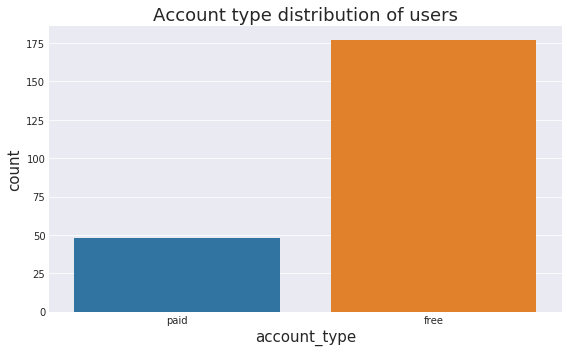

In [94]:
accountType_distribution_pd = pd.DataFrame({'account_type': ['paid', 'free'], 'count': [num_paid_accounts, num_free_accounts]})
display(accountType_distribution_pd)

plot_sns_bar(x='account_type',
             y='count', 
             data=accountType_distribution_pd, 
             title='Account type distribution of users', 
             xlabel='account_type', 
             ylabel='count', 
             save=True, 
             hide_xtick=False, 
             order=False)

### What are the web pages a user can visit?

In [26]:
df.select("page").dropDuplicates().sort("page").show(n=50)

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [156]:
page_elements = df.select("page").dropDuplicates().rdd.flatMap(lambda x: x).collect()

### Total page activity count

In [129]:
total_page_activity_count = df.select('userId', 'page').groupby('page').count()
total_page_activity_count.show()

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 14457|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   924|
| Submit Registration|     5|
|            Settings|  1514|
|               Login|  3241|
|            Register|    18|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Help|  1726|
|             Upgrade|   499|
+--------------------+------+
only showing top 20 rows



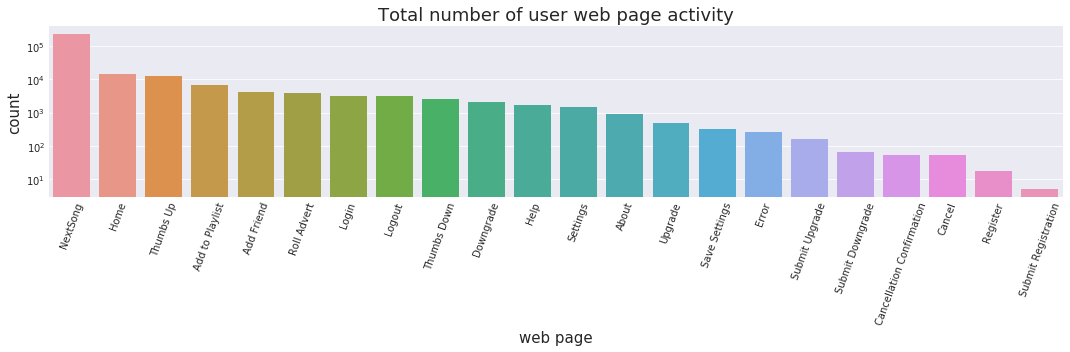

In [143]:
total_page_activity_count_pd = total_page_activity_count.toPandas()

plot_sns_bar(x='page',
             y='count', 
             data=total_page_activity_count_pd, 
             log=True, 
             title='Total number of user web page activity', 
             xlabel='web page', 
             ylabel='count', 
             figsize=(15,5),
             save=True, 
             hide_xtick=False, 
             rotation=70, 
             order=True, 
             sort_by='count', 
             ascending=False)

### Total number of songs played

In [29]:
df.where(df.page=='NextSong').count()

228108

## <a class="anchor" id="df_example_study">Study DataFrame for based on userId</a>

- Study the the DataFrame based on a provided userId. 
- Change the **userId in the next cell** to test different users

In [188]:
userId = 131

### Overview

In [189]:
# Overview
df.where(df.userId==userId).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
0,Metallica,Logged In,Kael,M,0,Baker,415.16363,free,"Kingsport-Bristol-Bristol, TN-VA",PUT,NextSong,1533102330000,249,Fade To Black,200,1538384355000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",131,0
1,Pearl Jam,Logged In,Kael,M,1,Baker,276.40118,free,"Kingsport-Bristol-Bristol, TN-VA",PUT,NextSong,1533102330000,249,Nothingman (Live),200,1538384770000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",131,0
2,Frumpies,Logged In,Kael,M,2,Baker,134.47791,free,"Kingsport-Bristol-Bristol, TN-VA",PUT,NextSong,1533102330000,249,Fuck Kitty,200,1538385046000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",131,0
3,Kaiser Chiefs,Logged In,Kael,M,3,Baker,222.82404,free,"Kingsport-Bristol-Bristol, TN-VA",PUT,NextSong,1533102330000,249,Half The Truth,200,1538385180000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",131,0
4,Kelly Clarkson,Logged In,Kael,M,4,Baker,156.65587,free,"Kingsport-Bristol-Bristol, TN-VA",PUT,NextSong,1533102330000,249,(You Make Me Feel Like A) Natural Woman,200,1538385402000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",131,0
5,Darude,Logged In,Kael,M,5,Baker,516.28363,free,"Kingsport-Bristol-Bristol, TN-VA",PUT,NextSong,1533102330000,249,Feel The Beat,200,1538385558000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",131,0
6,Bloc Party,Logged In,Kael,M,6,Baker,235.65016,free,"Kingsport-Bristol-Bristol, TN-VA",PUT,NextSong,1533102330000,249,Luno,200,1538386074000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",131,0
7,Helen Reddy,Logged In,Kael,M,7,Baker,211.35628,free,"Kingsport-Bristol-Bristol, TN-VA",PUT,NextSong,1533102330000,249,Angie Baby,200,1538386309000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",131,0
8,Cosmo Vitelli,Logged In,Kael,M,8,Baker,206.05342,free,"Kingsport-Bristol-Bristol, TN-VA",PUT,NextSong,1533102330000,249,Robot Soul (Radio Edit),200,1538386520000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",131,0
9,Eminem,Logged In,Kael,M,9,Baker,251.55873,free,"Kingsport-Bristol-Bristol, TN-VA",PUT,NextSong,1533102330000,249,Without Me,200,1538386726000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",131,0


### Get user's sessionIds 

In [190]:
# helper function - get all sessions for user with userId
def get_sessionIds_for_userId(df, userId):
    sessionId_list = df.where(df.userId==userId).select('sessionId').drop_duplicates(subset=['sessionId']).rdd.flatMap(lambda x: x).collect()
    return sessionId_list
get_sessionIds_for_userId(df, userId)

[2041,
 320,
 2281,
 1164,
 1071,
 929,
 1536,
 1000,
 1187,
 249,
 440,
 2155,
 1095,
 1881,
 690,
 676,
 2094,
 885,
 1325]

### Get user page activities for a certain session
- Change **sessionId in the next cell** to check page activities of different sessions

In [191]:
sessionId = 131

In [192]:
# helper function - get list of activities for user with userId in session with sesionId
def get_user_activities_for_session(df, userId, sessionId):
    page_names_list = df.where((df.userId==userId) & (df.sessionId==sessionId)).select('page').rdd.flatMap(lambda x: x).collect()
    return page_names_list

get_user_activities_for_session(df, userId, sessionId)

[]

In [193]:
def get_user_activity_statistic(df, userId):
    user_activity_dict = {}
    for key in page_elements:
        user_activity_dict[key] = 0

    sessionId_list = get_sessionIds_for_userId(df, userId) 
    for sessionId in sessionId_list:
        page_names_list_in_session = get_user_activities_for_session(df, userId, sessionId)
        for element in page_names_list_in_session:
             user_activity_dict[element] +=1
    
    
    user_activity_dict_df = pd.DataFrame(user_activity_dict, index=[0])
    
    return user_activity_dict_df

### Short user report info

In [194]:
def get_user_info(df, userId): 
    printmd('### user with userId = ' + str(userId))
   
    # number of total user actions
    printmd('#### number of total user actions')
    print(df.where(df.userId==userId).count())
 
    # paid or free user
    printmd('#### number of paid and/or free entries')
    df.where(df.userId==userId).groupby('level').count().show()
    
    # number of sessions
    num_session = df.where(df.userId==userId).groupby('sessionId').count().count()
    printmd('#### number of sessions')
    print(num_session)
    
    # session overview
    printmd('#### session activities count')
    df.where(df.userId==userId).groupby('sessionId').count().show()
    
    # number of songs played per session
    printmd('#### number of songs played per session')
    df.where((df.userId==userId) & (df.page=='NextSong')).groupby('sessionId').count().show()
    
    # mean Number of played songs per session 
    mean_num_plyed_songs =df.where((df.userId==userId) & (df.artist!='None')).groupby('sessionId').count().select(_mean(col('count')).alias('avg_num_songs_per_session'))
    printmd('#### mean number of played songs per session')
    mean_num_plyed_songs.show()
    
    # get all user's sessionIds
    sessionId_list = df.where(df.userId==userId).select('sessionId').drop_duplicates(subset=['sessionId']).rdd.flatMap(lambda x: x)
    printmd('#### all user sessionIds')
    print(sessionId_list.collect())
    
    # get all user's overall web page activity
    user_activity_dict_df = get_user_activity_statistic(df, userId)
    printmd('#### web page activity')
    display(user_activity_dict_df)
    
get_user_info(df, userId)

### user with userId = 131

#### number of total user actions

1863


#### paid and/or free user

+-----+-----+
|level|count|
+-----+-----+
| free|  103|
| paid| 1760|
+-----+-----+



#### number of sessions

19


#### session activities count

+---------+-----+
|sessionId|count|
+---------+-----+
|     2041|  111|
|      320|   29|
|     2281|    1|
|     1164|  200|
|     1071|   16|
|      929|  247|
|     1536|  125|
|     1000|   70|
|     1187|  171|
|      249|  238|
|      440|   35|
|     2155|   61|
|     1095|    1|
|     1881|   55|
|      690|  136|
|      676|   36|
|     2094|    3|
|      885|  142|
|     1325|  186|
+---------+-----+



#### number of songs played per session

+---------+-----+
|sessionId|count|
+---------+-----+
|     2041|   92|
|      320|   24|
|     1164|  172|
|     1071|   11|
|      929|  206|
|     1536|  107|
|     1000|   57|
|     1187|  149|
|      249|  199|
|      440|   31|
|     2155|   48|
|     1881|   50|
|      690|  115|
|      676|   29|
|     2094|    2|
|      885|  124|
|     1325|  148|
+---------+-----+



#### mean number of played songs per session

+-------------------------+
|avg_num_songs_per_session|
+-------------------------+
|                     92.0|
+-------------------------+



#### all user sessionIds

[2041, 320, 2281, 1164, 1071, 929, 1536, 1000, 1187, 249, 440, 2155, 1095, 1881, 690, 676, 2094, 885, 1325]


#### web page activity

,Cancel,Submit Downgrade,Thumbs Down,Home,Downgrade,Roll Advert,Logout,Save Settings,Cancellation Confirmation,About,...,Login,Register,Add to Playlist,Add Friend,NextSong,Thumbs Up,Help,Upgrade,Error,Submit Upgrade
0,0,2,20,54,15,5,18,2,0,5,...,0,0,51,26,1564,72,13,1,4,1


### Create time/duration columns

In [101]:
def create_hour_column(df):
    # Add a new column called 'hour'
    df = df.withColumn("hour", get_hour(df.ts))
    return df

def create_seconds_column(df):
    # Add a new column called 'seconds'
    df = df.withColumn("seconds", get_seconds(df.ts))
    return df

def get_session_page_duration(df, userId, sessionId):
    # get activities for a certain user sessionId
    session_activities = df.where((df.userId==userId) & (df.sessionId==sessionId)).select('sessionId', 'page', 'seconds', 'ts')

    
    session_window = Window.partitionBy().orderBy("ts")

    session_activities = session_activities.withColumn("next_value", F.lead(session_activities.seconds).over(session_window))
    session_activities = session_activities.withColumn("page_duration_in_sec", F.when(F.isnull(session_activities.next_value - session_activities.seconds), 0)
                                  .otherwise(session_activities.next_value - session_activities.seconds))
    
    
    return session_activities


# Add hour column
df = create_hour_column(df)
# Add seconds column
df = create_seconds_column(df)


session_activities = get_session_page_duration(df, userId=userId, sessionId=sessionId)
session_activities.show()

NameError: name 'userId' is not defined

# <a class="anchor" id="data_prep">Data Preparation</a>

## <a class="anchor" id="filter_data">Drop missing/uncommon values</a>

In [51]:
df.count()

278154

In [52]:
df_clean = df.dropna(how = "any", subset = ["userId", "sessionId"])
df_clean = df_clean.filter(df_clean["userId"] != "")

In [53]:
df_clean.count()

278154

## <a class="anchor" id="churn">Define Churn - The Label for Machine Learning Modeling</a>

In [54]:
# Create a churn column - get churn for eachuser --> churn=1 (user churned), churn=0 (user not churned) 
flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df_clean = df_clean.withColumn('churn_event', flag_churn_event('page'))
df_clean = df_clean.withColumn('churn', max('churn_event').over(Window.partitionBy('userId')))

In [58]:
df_clean.select('userId', 'churn').dropDuplicates(['userId']).where(df_clean.churn ==1).count()

52

In [57]:
df_clean.select('userId', 'churn').dropDuplicates(['userId']).where(df_clean.churn ==0).count()

173

## <a class="anchor" id="Distribution_of_churned_and_non_churned_users">Distribution of churned and non churned users</a>

+-----+-----+
|churn|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



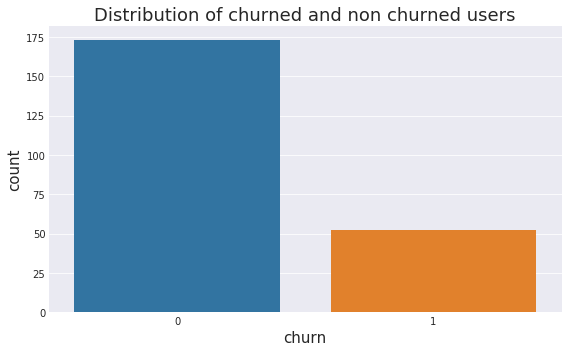

In [65]:
number_churn = df_clean.dropDuplicates(['userId']).groupby(['churn']).count()
number_churn.show()
number_churn_pd = number_churn.toPandas()


plot_sns_bar(x='churn',
             y='count', 
             data=number_churn_pd, 
             title='Distribution of churned and non churned users', 
             xlabel='churn', 
             ylabel='count', 
             save=True, 
             hide_xtick=False, 
             order=False)

#### Result:
- 23.11 % of all users churned

In [202]:
num_churn = 52
num_non_churn = 173

# <a class="anchor" id="Exploratory_Data_Analysis2">Exploratory Data Analysis Part 2</a>

## <a class="anchor" id="Gender_distribution_based_on_churn">Gender distribution based on churn</a>

In [161]:
### Gender distribution of users
gender_distribution = df_clean.drop_duplicates(subset=['userId']).groupby('gender').count()
gender_distribution.show()

+------+-----+
|gender|count|
+------+-----+
|     F|  104|
|     M|  121|
+------+-----+



,gender,count
0,F,104
1,M,121


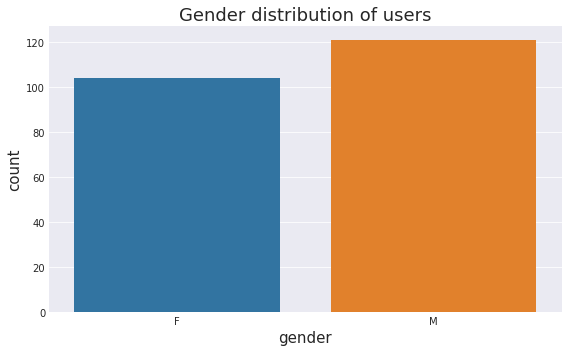

In [162]:
gender_distribution_pd = gender_distribution.toPandas()
display(gender_distribution_pd)
plot_sns_bar(x='gender',
             y='count', 
             data=gender_distribution_pd, 
             title='Gender distribution of users', 
             xlabel='gender', 
             ylabel='count', 
             save=True, 
             hide_xtick=False, 
             order=False)

#### Result:
- 46.22% of all users are women
- 53.78% of all users are men

In [209]:
get_percentage_gender = udf(lambda x, y : x /121*100 if y=='M' else x /104*100)
gender_distribution_churn = df_clean.dropDuplicates(['userId', 'gender']).groupby(['churn', 'gender']).count().sort('churn')
#gender_distribution_churn.show()
gender_distribution_churn = gender_distribution_churn.withColumn('count_percentage', get_percentage(gender_distribution_churn['count'].cast(FloatType()), gender_distribution_churn['gender']))
gender_distribution_churn.show()

+-----+------+-----+-------------------+
|churn|gender|count|   count_percentage|
+-----+------+-----+-------------------+
|    0|     M|   89| 0.7355371900826446|
|    0|     F|   84| 0.8076923076923077|
|    1|     F|   20|0.19230769230769232|
|    1|     M|   32| 0.2644628099173554|
+-----+------+-----+-------------------+



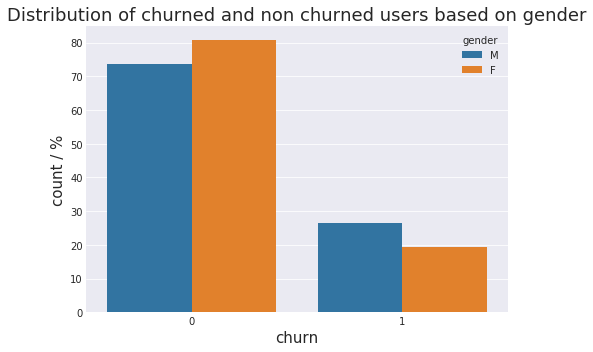

In [210]:
gender_distribution_churn_pd = gender_distribution_churn.toPandas()
gender_distribution_churn_pd['count_percentage'] = gender_distribution_churn_pd['count_percentage'].astype(float) *100
plot_sns_bar(x='churn',
             y='count_percentage', 
             data=gender_distribution_churn_pd, 
             hue='gender',
             title='Distribution of churned and non churned users based on gender', 
             xlabel='churn', 
             ylabel='count / %', 
             legend='gender',
             save=True, 
             hide_xtick=False, 
             order=False)

#### Result:
- There is no clear trend that women tend mor to churn 
- Gender seems not to be an important feature to predict churn

In [151]:
# membership_duration
membership_duration= df_clean.select('userId','registration','ts','churn')
membership_duration = membership_duration.withColumn('membership_duration',(get_days(df_clean.ts - df_clean.registration)))
membership_duration = membership_duration.groupBy('userId','churn').agg({'membership_duration':'max'})                                                   
membership_duration.show()

+------+-----+------------------------+
|userId|churn|max(membership_duration)|
+------+-----+------------------------+
|    19|    0|      21.451435185185186|
|100005|    1|       85.19559027777778|
|200007|    0|       53.39774305555556|
|300007|    1|      11.553703703703704|
|200002|    0|       70.07462962962963|
|    50|    0|       75.44710648148148|
|100011|    1|       5.165115740740741|
|100012|    1|       43.05261574074074|
|    30|    0|       9.673993055555556|
|     8|    0|       95.37923611111111|
|     4|    0|       62.79774305555556|
|    65|    0|       71.10780092592593|
|   101|    1|              53.9659375|
|    13|    0|       98.05936342592592|
|   153|    0|        9.11613425925926|
|100014|    1|       85.08340277777778|
|    42|    0|       9.485104166666666|
|    62|    0|       97.05665509259259|
|    94|    0|       81.80175925925926|
|   114|    0|       71.39887731481481|
+------+-----+------------------------+
only showing top 20 rows



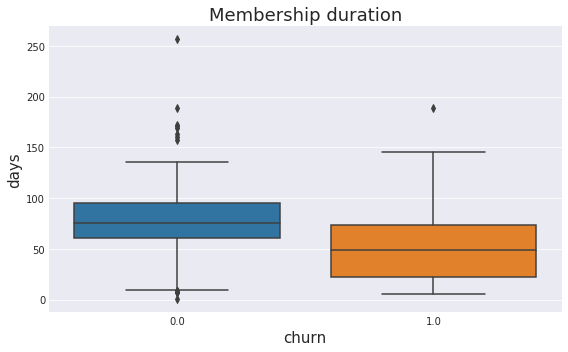

In [222]:
membership_duration_pd = membership_duration.withColumnRenamed('max(membership_duration)','membership_duration').select('userId', 'churn', 'membership_duration').toPandas()
membership_duration_pd = membership_duration_pd.astype(np.float)
#display(membership_duration_pd)
plot_sns_box(x='churn', 
             y='membership_duration', 
             data=membership_duration_pd, 
             title='Membership duration', 
             xlabel='churn', 
             ylabel='days', 
             legend='churn', 
             figsize=(8,5), 
             save=False, 
             hide_xtick=False, 
             rotation=0, 
             order=False, 
             sort_by='', 
             ascending=False)

#### Result:
- User with a longer membership have a lower tendency to churn

## <a class="anchor" id="Total_page_activity_based_on_churn">Total page activity based on churn</a>

In [207]:
get_percentage_churn = udf(lambda x,y: x / num_churn * 100 if y==1 else x/ num_non_churn * 100)
total_page_activity_churn = df_clean.dropDuplicates(['userId', 'page']).groupby('page', 'churn').count()
#total_page_activity_churn.show()
total_page_activity_churn = total_page_activity_churn.withColumn('count_percentage', get_percentage_churn(total_page_activity_churn['count'].cast(FloatType()), total_page_activity_churn['churn']))
total_page_activity_churn.show()


+---------------+-----+-----+------------------+
|           page|churn|count|  count_percentage|
+---------------+-----+-----+------------------+
|      Thumbs Up|    0|  170| 98.26589595375722|
|        Upgrade|    0|  131| 75.72254335260115|
|         Logout|    0|  167| 96.53179190751445|
|        Upgrade|    1|   37| 71.15384615384616|
|     Add Friend|    1|   44| 84.61538461538461|
|          Error|    1|   22| 42.30769230769231|
|           Home|    1|   51| 98.07692307692307|
|       NextSong|    0|  173|             100.0|
| Submit Upgrade|    0|  102| 58.95953757225434|
|           Help|    0|  149|  86.1271676300578|
|Add to Playlist|    1|   50| 96.15384615384616|
|  Save Settings|    0|  102| 58.95953757225434|
|  Save Settings|    1|   30|57.692307692307686|
|           Home|    0|  172| 99.42196531791907|
|Add to Playlist|    0|  165| 95.37572254335261|
|       Settings|    0|  152| 87.86127167630057|
|      Thumbs Up|    1|   50| 96.15384615384616|
|    Thumbs Down|   

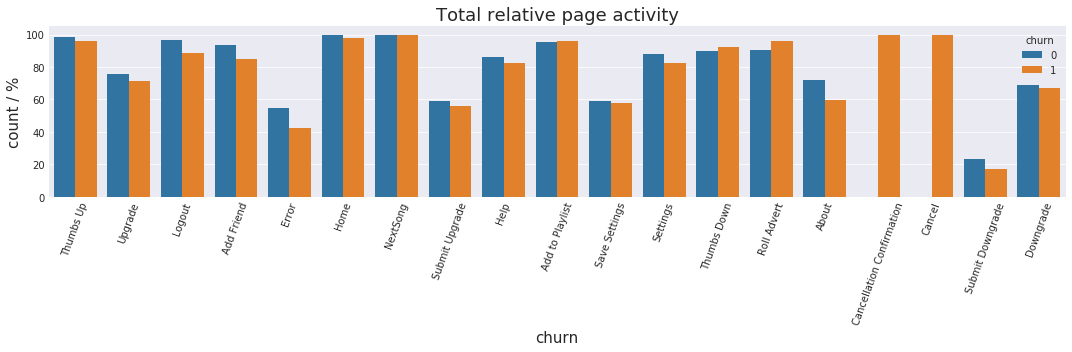

In [212]:
total_page_activity_churn_pd = total_page_activity_churn.toPandas()
total_page_activity_churn_pd['count_percentage'] = total_page_activity_churn_pd['count_percentage'].astype(float)
plot_sns_bar(x='page', 
             y='count_percentage', 
             hue='churn',
             data=total_page_activity_churn_pd, 
             title='Total relative page activity', 
             xlabel='churn', 
             ylabel='count / %', 
             legend='', 
             figsize=(15,5), 
             save=False, 
             hide_xtick=False, 
             rotation=70, 
             order=False, 
             sort_by='', 
             ascending=False)

#### Result:
- The trends for some pages are not fully significant from this inspection
- However: It seems that the relative count of 'Add Friend', 'Thumbs Up' are interesting features wrt predicting churn. Thes relative count is here higher for non-churned users than for churned users.
- In contrast: 'Thumb Down' is higher for churned users than for non churned users. This feature could be also intersting for predicting churn.
- It could be, that in larger datasets those trends are more significant than here.

## <a class="anchor" id="total_number_of_songs_played_by_user">Total number of songs played by user</a>

In [218]:
# mean Number of played songs per session 
num_songs_played_user_session = df_clean.select('userId', 'sessionId', 'churn').where(df_clean.page=='NextSong').groupby('userId','sessionId', 'churn').count().sort('userId')
num_songs_played_user_session.show()
total_num_songs_played_user = num_songs_played_user_session.select('userId', 'churn','count').groupby('userId', 'churn').sum('count').sort(desc('sum(count)'))
total_num_songs_played_user.show()

printmd('#### Number of events: '+ str(total_num_songs_played_user.count()))

+------+---------+-----+-----+
|userId|sessionId|churn|count|
+------+---------+-----+-----+
|    10|     1047|    0|   21|
|    10|        9|    0|   57|
|    10|      595|    0|  381|
|    10|     1414|    0|   63|
|    10|     1592|    0|   67|
|    10|     1981|    0|   84|
|   100|      435|    0|   15|
|   100|      991|    0|   17|
|   100|     1505|    0|   46|
|   100|      369|    0|   91|
|   100|     1353|    0|   10|
|   100|     1279|    0|   26|
|   100|     1473|    0|  184|
|   100|      256|    0|  148|
|   100|     1185|    0|  144|
|   100|     1299|    0|   80|
|   100|     1231|    0|   16|
|   100|      707|    0|  180|
|   100|     1269|    0|    3|
|   100|     1398|    0|   30|
+------+---------+-----+-----+
only showing top 20 rows

+------+-----+----------+
|userId|churn|sum(count)|
+------+-----+----------+
|    39|    0|      8002|
|    92|    0|      5945|
|   140|    0|      5664|
|300011|    0|      4619|
|   124|    0|      4079|
|300021|    0|      38

#### Number of events: 225

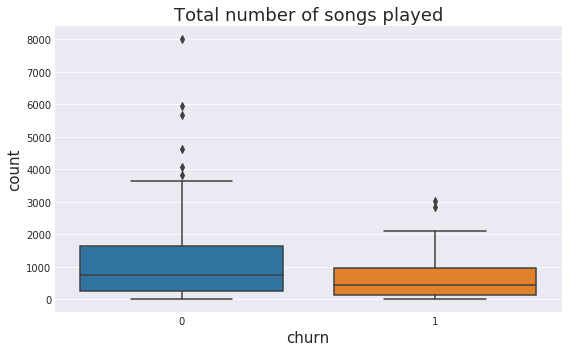

In [220]:
total_num_songs_played_user_pd = total_num_songs_played_user.toPandas()
#display(total_num_songs_played_user_pd.iloc[:20])


plot_sns_box(x='churn', 
             y='sum(count)', 
             data=total_num_songs_played_user_pd, 
             title='Total number of songs played', 
             xlabel='churn', 
             ylabel='count', 
             legend='churn', 
             figsize=(8,5), 
             save=False, 
             hide_xtick=False, 
             rotation=0, 
             order=False, 
             sort_by='', 
             ascending=False)

#### Result:
- Non churned user play more songs than churned ones
- Non churned user seem to be more active, they seem to listen to songs on Sparkify more frequently
- num_songs_played_user_session seems to be a useful feature to predict churn

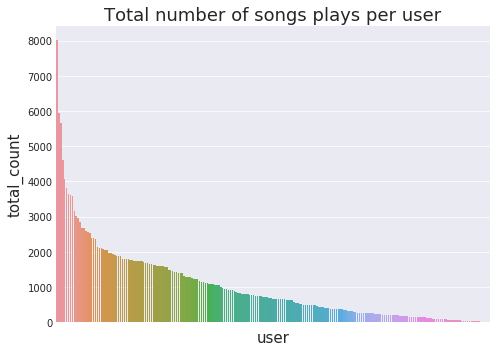

In [67]:
total_num_songs_played_user_pd = total_num_songs_played_user.toPandas()
#display(total_num_songs_played_user_pd)
plot_sns_bar(x='userId',
             y='sum(count)', 
             data=total_num_songs_played_user_pd, 
             title='Total number of songs plays per user', 
             xlabel='user', 
             ylabel='total_count', 
             save=True, 
             hide_xtick=True, 
             order=True, 
             sort_by='sum(count)', 
             ascending=False)

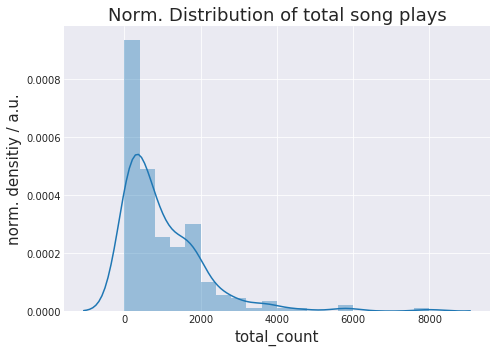

In [91]:
plot_sns_distplot(data=total_num_songs_played_user_pd, 
                  column_to_plot='sum(count)', 
                  title='Norm. Distribution of total song plays', 
                  xlabel='total_count', 
                  ylabel='norm. densitiy / a.u.', 
                  save=True, 
                  bins=20, 
                  kde=True, 
                  norm_hist=True)

## <a class="anchor" id="Average_number_of_songs_played_by_user_per_session">Average number of songs played per user per session</a>

In [229]:
# mean Number of played songs per session 
num_songs_played_user_session = df_clean.select('userId', 'sessionId', 'churn').where(df_clean.page=='NextSong').groupby('userId', 'sessionId', 'churn').count().sort('userId')
num_songs_played_user_session.show()
avg_num_songs_played_user_session = num_songs_played_user_session.select('userId', 'churn', 'count').groupby('userId', 'churn').mean('count').sort(desc('avg(count)'))
avg_num_songs_played_user_session.show()

printmd('#### Number of events: '+ str(avg_num_songs_played_user_session.count()))

+------+---------+-----+-----+
|userId|sessionId|churn|count|
+------+---------+-----+-----+
|    10|     1047|    0|   21|
|    10|        9|    0|   57|
|    10|      595|    0|  381|
|    10|     1414|    0|   63|
|    10|     1592|    0|   67|
|    10|     1981|    0|   84|
|   100|      435|    0|   15|
|   100|      991|    0|   17|
|   100|     1505|    0|   46|
|   100|      369|    0|   91|
|   100|     1353|    0|   10|
|   100|     1279|    0|   26|
|   100|     1473|    0|  184|
|   100|      256|    0|  148|
|   100|     1185|    0|  144|
|   100|     1299|    0|   80|
|   100|     1231|    0|   16|
|   100|      707|    0|  180|
|   100|     1269|    0|    3|
|   100|     1398|    0|   30|
+------+---------+-----+-----+
only showing top 20 rows

+------+-----+------------------+
|userId|churn|        avg(count)|
+------+-----+------------------+
|    91|    0| 286.6666666666667|
|    19|    0|             216.0|
|    51|    1|             211.1|
|    62|    0|           1

#### Number of events: 225

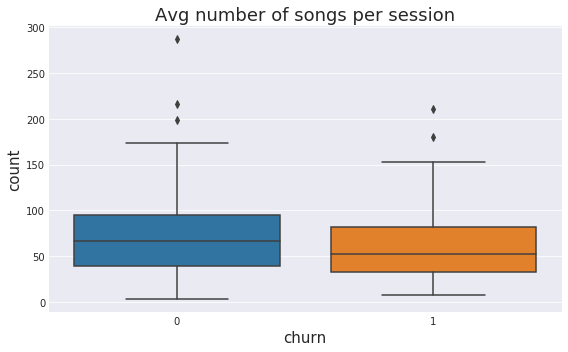

In [230]:
avg_num_songs_played_user_session_pd = avg_num_songs_played_user_session.toPandas()
#display(avg_num_songs_played_user_session_pd

plot_sns_box(x='churn', 
             y='avg(count)', 
             data=avg_num_songs_played_user_session_pd, 
             title='Avg number of songs per session', 
             xlabel='churn', 
             ylabel='count', 
             legend='churn', 
             figsize=(8,5), 
             save=False, 
             hide_xtick=False, 
             rotation=0, 
             order=False, 
             sort_by='', 
             ascending=False)

#### Result:
- Non churned user play more songs per session than churned ones
- Non churned user seem to be more active, they seem to listen to songs on Sparkify more frequently
- avg_num_songs_played_user_session seems to be a useful feature to predict churn

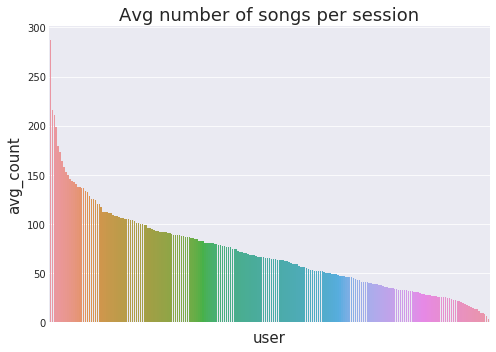

In [52]:
#display(avg_num_songs_playes_user_session_pd)
plot_sns_bar(x='userId',
             y='avg(count)', 
             data=avg_num_songs_played_user_session_pd, 
             title='Avg number of songs per session', 
             xlabel='user', 
             ylabel='avg_count', 
             save=True, 
             hide_xtick=True, 
             order=True, 
             sort_by='avg(count)', 
             ascending=False)

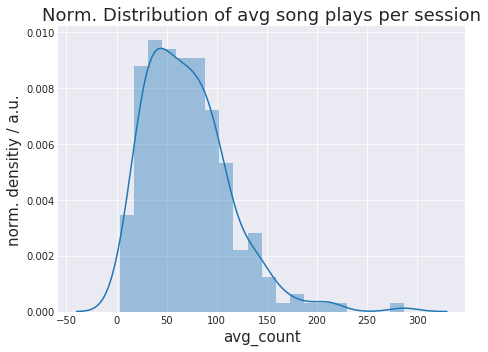

In [92]:
plot_sns_distplot(data=avg_num_songs_played_user_session_pd, 
                  column_to_plot='avg(count)', 
                  title='Norm. Distribution of avg song plays per session', 
                  xlabel='avg_count', 
                  ylabel='norm. densitiy / a.u.', 
                  save=True, 
                  bins=20, 
                  kde=True, 
                  norm_hist=True)

## <a class="anchor" id="total_number_of_thumbs_up_per_user">Total number of thumbs up per user</a>

In [231]:
thumbs_up = df_clean.select('userId', 'churn').where(df.page=='Thumbs Up').groupby('userId', 'churn').count().sort(desc('count'))
thumbs_up.show()

printmd('#### Number of events: '+ str(thumbs_up.count()))

+------+-----+-----+
|userId|churn|count|
+------+-----+-----+
|300011|    0|  437|
|    39|    0|  388|
|300021|    0|  336|
|300017|    0|  303|
|    92|    0|  292|
|   140|    0|  277|
|300015|    0|  193|
|    85|    0|  192|
|   124|    0|  171|
|300023|    0|  169|
|    42|    0|  166|
|     6|    0|  165|
|    54|    1|  163|
|200023|    0|  163|
|    29|    1|  154|
|   100|    0|  148|
|300001|    1|  148|
|300002|    0|  140|
|300025|    0|  139|
|   126|    0|  135|
+------+-----+-----+
only showing top 20 rows



#### Number of events: 220

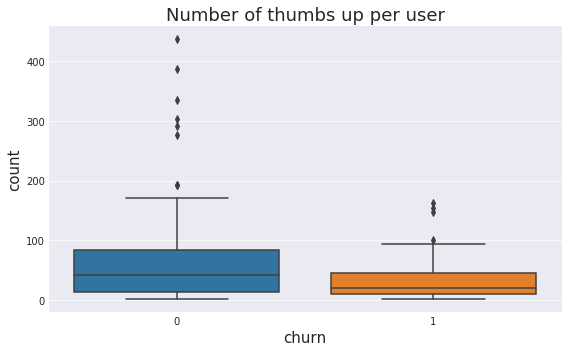

In [232]:
thumbs_up_pd = thumbs_up.toPandas()
#display(thumbs_up)

plot_sns_box(x='churn', 
             y='count', 
             data=thumbs_up_pd, 
             title='Number of thumbs up per user', 
             xlabel='churn', 
             ylabel='count', 
             legend='churn', 
             figsize=(8,5), 
             save=False, 
             hide_xtick=False, 
             rotation=0, 
             order=False, 
             sort_by='', 
             ascending=False)

#### Result:
- There are more 'thumbs up' for non churned user than for churned ones
- thumbs_up seems to be a useful feature to predict churn

In [ ]:
"""
thumbs_up = spark.sql('''
                      SELECT userId, count(*) as num_thumbs_up
                      FROM sparkify_sql_view 
                      where page = 'Thumbs Up' 
                      group by userId
                      ''')

thumbs_up.show()
"""

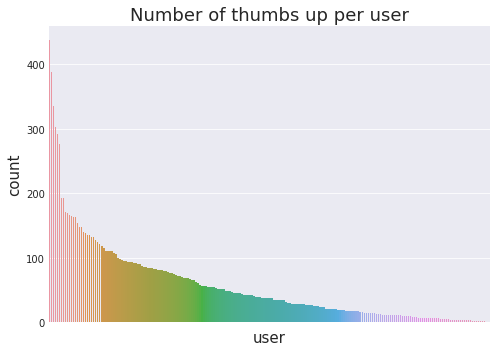

In [78]:
#display(thumbs_up_pd)

plot_sns_bar(x='userId',
             y='count', 
             data=thumbs_up_pd, 
             title='Number of thumbs up per user', 
             xlabel='user', 
             ylabel='count', 
             save=True, 
             hide_xtick=True, 
             order=True, 
             sort_by='count', 
             ascending=False)

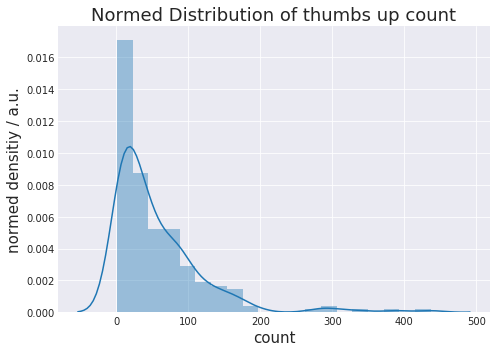

In [79]:
plot_sns_distplot(data=thumbs_up_pd, 
                  column_to_plot='count', 
                  title='Norm. Distribution of thumbs up count', 
                  xlabel='count', 
                  ylabel='norm. densitiy / a.u.', 
                  save=True, 
                  bins=20, 
                  kde=True, 
                  norm_hist=True)

## <a class="anchor" id="total_number_of_thumbs_down_per_user">Total number of thumbs down per user</a>

In [235]:
thumbs_down = df_clean.select('userId', 'churn').where(df_clean.page=='Thumbs Down').groupby('userId', 'churn').count().sort(desc('count'))
thumbs_down.show()

printmd('#### Number of events: '+ str(thumbs_down.count()))

+------+-----+-----+
|userId|churn|count|
+------+-----+-----+
|   140|    0|   75|
|200023|    0|   73|
|    92|    0|   72|
|    39|    0|   69|
|200004|    0|   54|
|200008|    0|   52|
|300011|    0|   41|
|   124|    0|   41|
|    85|    0|   38|
|200020|    1|   36|
|300021|    0|   36|
|200021|    1|   35|
|     9|    0|   32|
|200009|    0|   32|
|     6|    0|   31|
|    54|    1|   29|
|300017|    0|   28|
|200014|    0|   28|
|   118|    0|   27|
|200025|    0|   27|
+------+-----+-----+
only showing top 20 rows



#### Number of events: 203

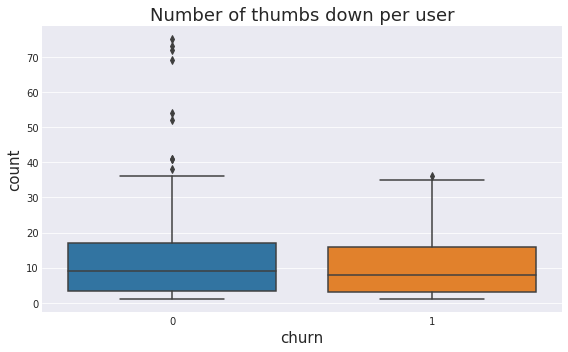

In [236]:
thumbs_down_pd = thumbs_down.toPandas()
#display(thumbs_up)

plot_sns_box(x='churn', 
             y='count', 
             data=thumbs_down_pd, 
             title='Number of thumbs down per user', 
             xlabel='churn', 
             ylabel='count', 
             legend='churn', 
             figsize=(8,5), 
             save=False, 
             hide_xtick=False, 
             rotation=0, 
             order=False, 
             sort_by='', 
             ascending=False)

#### Result:
- There are also slightly more 'thumbs down' for non churned user than for churned ones
- The trend of thumbs_down as a useful feature to predict churn is not clear at the moment

In [ ]:
"""
# SQL view 
df.createOrReplaceTempView("sparkify_sql_view")
thumbs_down = spark.sql('''
                        SELECT userId, count(*) as num_thumbs_down 
                        FROM sparkify_sql_view 
                        where page = 'Thumbs Down' 
                        group by userId
                        ''')

thumbs_down.show()
"""

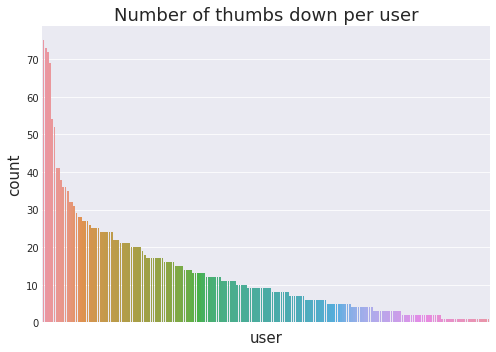

In [81]:
#display(thumbs_up_pd)

plot_sns_bar(x='userId',
             y='count', 
             data=thumbs_down_pd, 
             title='Number of thumbs down per user', 
             xlabel='user', 
             ylabel='count', 
             save=True, 
             hide_xtick=True, 
             order=True, 
             sort_by='count', 
             ascending=False)

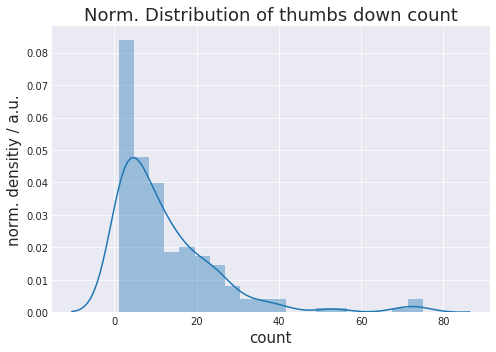

In [93]:
plot_sns_distplot(data=thumbs_down_pd, 
                  column_to_plot='count', 
                  title='Norm. Distribution of thumbs down count', 
                  xlabel='count', 
                  ylabel='norm. densitiy / a.u.', 
                  save=True, 
                  bins=20, 
                  kde=True, 
                  norm_hist=True)

## <a class="anchor" id="Total_number_of_errors_per_user">Total number of errors per user</a>

In [239]:
error = df_clean.select('userId', 'churn').where(df_clean.page=='Error').groupby('userId', 'churn').count().sort(desc('count'))
error.show()

printmd('#### Number of events: '+ str(error.count()))

+------+-----+-----+
|userId|churn|count|
+------+-----+-----+
|    39|    0|    7|
|    42|    0|    7|
|   140|    0|    7|
|   124|    0|    6|
|   142|    0|    5|
|300017|    0|    5|
|    95|    0|    5|
|300021|    0|    5|
|     4|    0|    4|
|   131|    0|    4|
|    49|    0|    4|
|     6|    0|    4|
|300015|    0|    4|
|    69|    0|    4|
|    59|    0|    4|
|    62|    0|    4|
|300023|    0|    3|
|   100|    0|    3|
|   155|    0|    3|
|300008|    0|    3|
+------+-----+-----+
only showing top 20 rows



#### Number of events: 117

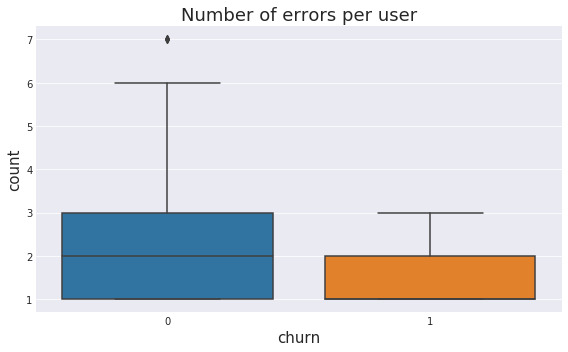

In [240]:
error_pd = error.toPandas()
#display(thumbs_up)

plot_sns_box(x='churn', 
             y='count', 
             data=error_pd, 
             title='Number of errors per user', 
             xlabel='churn', 
             ylabel='count', 
             legend='churn', 
             figsize=(8,5), 
             save=False, 
             hide_xtick=False, 
             rotation=0, 
             order=False, 
             sort_by='', 
             ascending=False)

#### Result:
- The error trend does not seem to influence churn dramatically.
- It seems that errors are forgiven. 
- Maybe the reason for that could be, that the amount of errors is small. Median < 2.

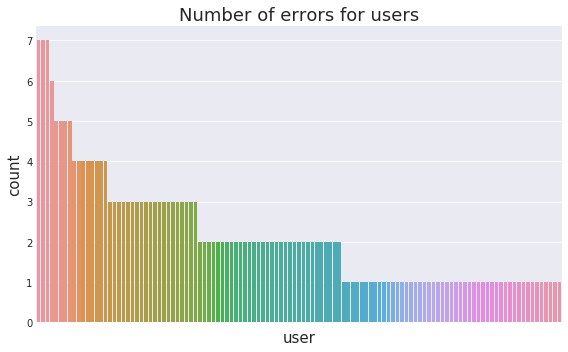

In [242]:
#display(thumbs_up_pd)

plot_sns_bar(x='userId',
             y='count', 
             data=error_pd, 
             title='Number of errors for users', 
             xlabel='user', 
             ylabel='count', 
             save=True, 
             hide_xtick=True, 
             order=True, 
             sort_by='count', 
             ascending=False)

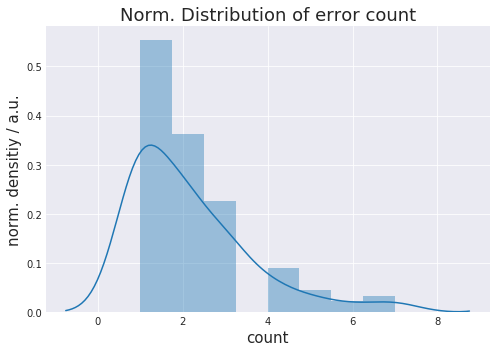

In [98]:
plot_sns_distplot(data=error_pd, 
                  column_to_plot='count', 
                  title='Norm. Distribution of error count', 
                  xlabel='count', 
                  ylabel='norm. densitiy / a.u.', 
                  save=True, 
                  bins=8, 
                  kde=True, 
                  norm_hist=True)

## <a class="anchor" id="Total_number_of_Add_to_playlist_clicks_per_user">Total number of "Add to playlist" clicks per user</a>

In [245]:
add_to_playlist = df_clean.select('userId', 'churn').where(df_clean.page=='Add to Playlist').groupby('userId', 'churn').count().sort(desc('count'))
add_to_playlist.show()

printmd('#### Number of events: '+ str(add_to_playlist.count()))

+------+-----+-----+
|userId|churn|count|
+------+-----+-----+
|    39|    0|  240|
|    92|    0|  181|
|   140|    0|  148|
|300011|    0|  146|
|   124|    0|  118|
|300017|    0|  113|
|    85|    0|  108|
|300021|    0|  107|
|    42|    0|  104|
|    29|    1|   89|
|     6|    0|   83|
|    74|    0|   80|
|     9|    0|   77|
|200023|    0|   73|
|   126|    0|   72|
|    54|    1|   72|
|300001|    1|   69|
|    65|    0|   68|
|200004|    0|   67|
|   138|    0|   67|
+------+-----+-----+
only showing top 20 rows



#### Number of events: 215

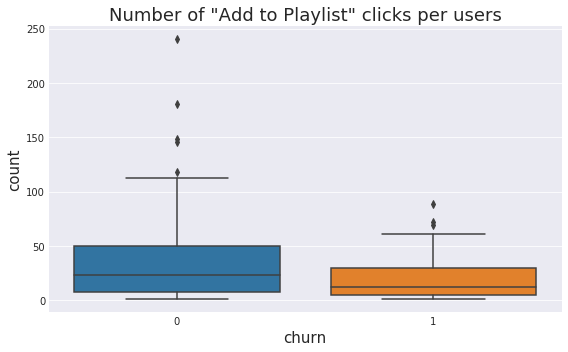

In [246]:
add_to_playlist_pd = add_to_playlist.toPandas()
#display(thumbs_up)

plot_sns_box(x='churn', 
             y='count', 
             data=add_to_playlist_pd, 
             title='Number of "Add to Playlist" clicks per users', 
             xlabel='churn', 
             ylabel='count', 
             legend='churn', 
             figsize=(8,5), 
             save=False, 
             hide_xtick=False, 
             rotation=0, 
             order=False, 
             sort_by='', 
             ascending=False)

#### Result:
- There are more 'Add to Playlist' events for non churned user than for churned ones
- add_to_playlist seems to be a useful feature to predict churn

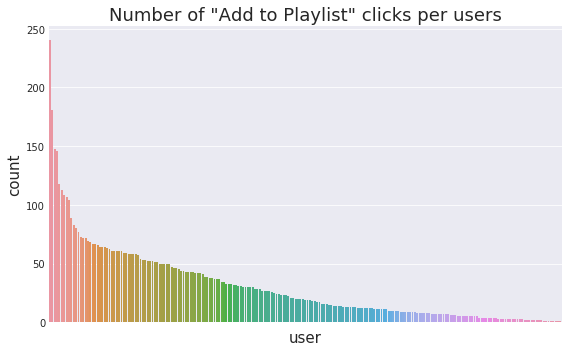

In [247]:
#display(thumbs_up_pd)

plot_sns_bar(x='userId',
             y='count', 
             data=add_to_playlist_pd, 
             title='Number of "Add to Playlist" clicks per users', 
             xlabel='user', 
             ylabel='count', 
             save=True, 
             hide_xtick=True, 
             order=True, 
             sort_by='count', 
             ascending=False)

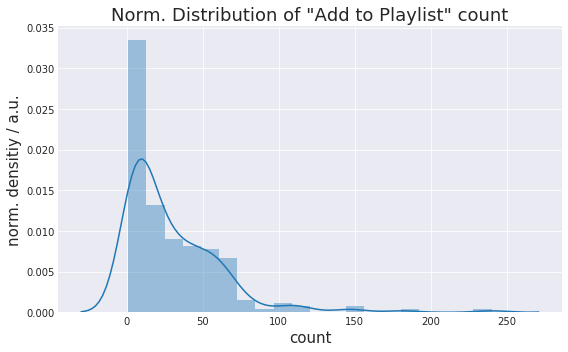

In [248]:
plot_sns_distplot(data=add_to_playlist_pd, 
                  column_to_plot='count', 
                  title='Norm. Distribution of "Add to Playlist" count', 
                  xlabel='count', 
                  ylabel='norm. densitiy / a.u.', 
                  save=True, 
                  bins=20, 
                  kde=True, 
                  norm_hist=True)

## <a class="anchor" id="Total_number_of_Add_Friend_clicks_per_user">Total number of "Add Friend" clicks per user</a>

In [249]:
add_friend = df_clean.select('userId', 'churn').where(df_clean.page=='Add Friend').groupby('userId', 'churn').count().sort(desc('count'))
add_friend.show()

printmd('#### Number of events: '+ str(add_friend.count()))

+------+-----+-----+
|userId|churn|count|
+------+-----+-----+
|   140|    0|  143|
|    39|    0|  122|
|    92|    0|  110|
|300011|    0|   93|
|300021|    0|   89|
|   124|    0|   74|
|200023|    0|   66|
|300017|    0|   63|
|   136|    0|   60|
|    85|    0|   58|
|    65|    0|   53|
|   118|    0|   52|
|    42|    0|   52|
|   100|    0|   49|
|    29|    1|   47|
|300015|    0|   47|
|     4|    0|   46|
|    98|    0|   45|
|    74|    0|   43|
|    91|    0|   42|
+------+-----+-----+
only showing top 20 rows



#### Number of events: 206

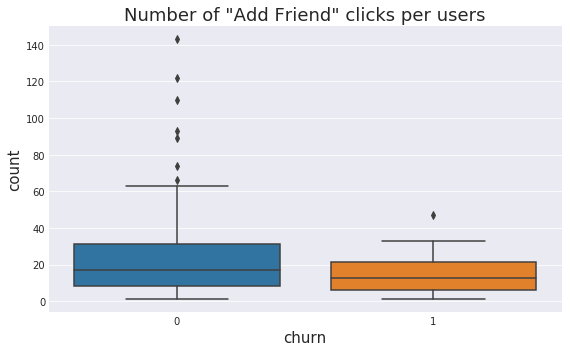

In [250]:
add_friend_pd = add_friend.toPandas()
#display(thumbs_up)

plot_sns_box(x='churn', 
             y='count', 
             data=add_friend_pd, 
             title='Number of "Add Friend" clicks per users', 
             xlabel='churn', 
             ylabel='count', 
             legend='churn', 
             figsize=(8,5), 
             save=False, 
             hide_xtick=False, 
             rotation=0, 
             order=False, 
             sort_by='', 
             ascending=False)

#### Result:
- There are more 'Add Friend' events for non churned user than for churned ones
- add_friend seems to be a useful feature to predict churn

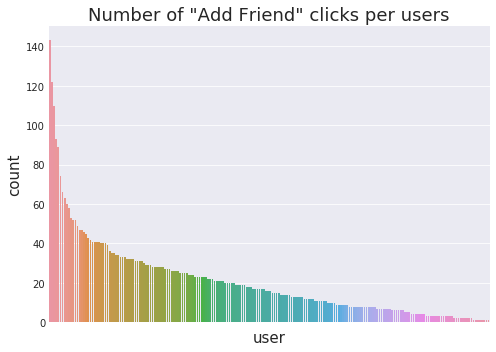

In [107]:
#display(add_friend_pd)

plot_sns_bar(x='userId',
             y='count', 
             data=add_friend_pd, 
             title='Number of "Add Friend" clicks per users', 
             xlabel='user', 
             ylabel='count', 
             save=True, 
             hide_xtick=True, 
             order=True, 
             sort_by='count', 
             ascending=False)

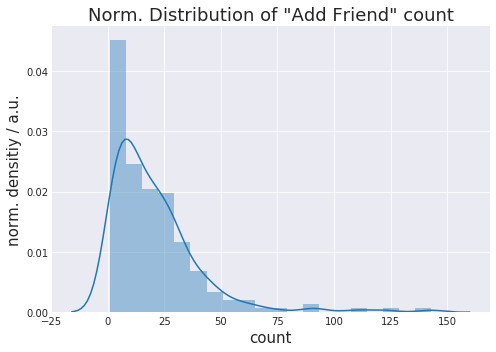

In [108]:
plot_sns_distplot(data=add_friend_pd, 
                  column_to_plot='count', 
                  title='Norm. Distribution of "Add Friend" count', 
                  xlabel='count', 
                  ylabel='norm. densitiy / a.u.', 
                  save=True, 
                  bins=20, 
                  kde=True, 
                  norm_hist=True)

# <a class="anchor" id="Feature_Engineering">Feature Engineering</a>
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [ ]:
df.filter("page = 'Cancellation Confirmation'").count()

In [ ]:
df_pd = df.filter("page = 'Downgrade'").toPandas()
df_pd

In [ ]:
df.filter("page = 'Downgrade'").count()

In [ ]:
churn = udf(lambda x: int(x=="Cancellation Confirmation"), IntegerType())
downgrade_churn = udf(lambda x: int(x=="Downgrade"), IntegerType())

df = df.withColumn("downgraded", downgrade_churn("page")).withColumn("cancelled", churn("page"))



In [ ]:
#distribution of users downgrades and cancellations
df.select(['userId', 'downgraded', 'cancelled'])\
    .groupBy('userId').sum()\
    .withColumnRenamed('sum(downgraded)', 'downgraded')\
    .withColumnRenamed('sum(cancelled)', 'cancelled').describe().show()

In [ ]:
windowvalue = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)


df = df.withColumn("churn_phase", Fsum("cancelled").over(windowvalue))\
    .withColumn("downgrade_phase", Fsum("downgraded").over(windowvalue))

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.